# Modeling - Option 1:
## predicting affluence in our NYC clusters

In the prior Data Cleaning & Exploratory Data Analysis notebook - we noted some very interesting insights based on the relative percentages of business types in each NYC Borough.

Here are some example observations we made, related to business categories within the borough: 
- Manhattan has a higher percentage of coffee shops
- Bronx and Staten Island have a higher percentage of Pizza shops
- Queens businesses lean toward Chinese restaurants
- Staten Island has the highest percentage of Hot Dog businesses

Also, we had made some observations based on the business 'price' level (example: \$\$)
- Manhattan has a predominance of 2 dollar sign businesses 
- Manhattan also the largest percentage of 3 and 4 dollar-sign businesses relative to the other boroughs
- Bronx contains predominantly 1 dollar sign businesses.

We believe that these observations are key in highlighting the relative types of businesses within a neighborhood. In this notebook, we explore these types of questions via modeling methods - to establish whether we can predict the affluence of one of our business 'clusters' by utilizing the percentages of types of businesses within all clusters.

We will train and test our model based on the relative fractional presence of businesses within each cluster...

(in progress!)

## Import Libraries and Data

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn import svm

from sklearn.metrics import confusion_matrix, roc_curve, auc, make_scorer, roc_auc_score

import matplotlib

# Styling 
from IPython.display import HTML, display
import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline


### Load data

In [2]:
# Import our clean yelp data, with the cluster and 'is_affluent' columns

yelp = pd.read_csv('../data/yelp_clean.csv')

## Feature fractions & modeling

In [3]:
# Quick view of the data set
yelp.head()

,Unnamed: 0,name,review_count,rating,price,cat1,zip_code,nyc,borough,cluster,is_affluent
0,0,Com Tam Ninh Kieu,379,4.0,2,vietnamese,10468,True,Bronx,12,0
1,1,Antonio's Trattoria,773,4.5,2,italian,10458,True,Bronx,12,0
2,2,Bronx Alehouse,749,4.0,2,tradamerican,10463,True,Bronx,62,0
3,4,The Bronx Public,443,4.0,2,sportsbars,10463,True,Bronx,62,0
4,5,Trattoria Zero Otto Nove,749,4.0,2,italian,10458,True,Bronx,12,0


In [4]:
# Define function to calculate the percentage presence for each feature category across all the others
# In our current use case, the group is our cluster and the fraction is the % of the feature type (price or category)
def class_fraction_feature(df_feature, group_col, feature_col):
    '''Function to create percent features. Take in a data frame, df_feature, collect the 
    categories in the group_col identify the features in feature_col and give a percent of the feature for the group.
    '''
    # identify unique groups and the unique features
    groups   = df_feature[group_col].unique().tolist()
    features = df_feature[feature_col].unique().tolist()    
    
    # Create a dictionary to store the groups. Iterate through the groups and collect counts for the features
    data = []
    for g in groups:
        # empty dictionary to fill up the group
        g_dict = {'group_col':g}
        
        for f in features:
            g_dict[f] = df_feature[(df_feature[group_col]==g)&(df_feature[feature_col]==f)][feature_col].count()
    
        # append the dictionary entry for a group to the list of groups
        data.append(g_dict)
        
    data = pd.DataFrame(data)
    
    # Create total by row and create fraction on each column
    data['total'] = data[features].sum(axis = 1)
    for f in features:
        data[ str(f) + '_fraction'] = data[f]/data['total']
   
    return data

In [5]:

# Calculating the percentages for each business type
cluster_price_fraction = class_fraction_feature(yelp,'cluster','price')
cluster_type_fraction = class_fraction_feature(yelp,'cluster','cat1')


In [6]:
# Show the cluster_price_fraction
cluster_price_fraction

,group_col,2,1,3,4,total,2_fraction,1_fraction,3_fraction,4_fraction
0,12,76,129,3,1,209,0.363636,0.617225,0.014354,0.004785
1,62,72,69,3,0,144,0.500000,0.479167,0.020833,0.000000
2,42,70,74,1,0,145,0.482759,0.510345,0.006897,0.000000
3,38,21,70,0,0,91,0.230769,0.769231,0.000000,0.000000
4,56,42,108,0,1,151,0.278146,0.715232,0.000000,0.006623
...,...,...,...,...,...,...,...,...,...,...
74,59,110,85,3,1,199,0.552764,0.427136,0.015075,0.005025
75,71,8,22,0,0,30,0.266667,0.733333,0.000000,0.000000
76,64,78,117,7,1,203,0.384236,0.576355,0.034483,0.004926
77,51,19,35,0,0,54,0.351852,0.648148,0.000000,0.000000


In [7]:
# Create a reference dataframe of the cluster numbers and their affluence category
cluster_is_affluent = yelp[['cluster', 'is_affluent']]
cluster_is_affluent = cluster_is_affluent.drop_duplicates(keep ='first')

In [8]:
# Join the fractions together to create a combined set for the clusters
cluster_fraction = cluster_price_fraction.merge(cluster_type_fraction, on = 'group_col', suffixes = ('_x','_y'))

# join on affluence
cluster_fraction = cluster_fraction.rename(columns={'group_col':'cluster'})
cluster_fraction = cluster_is_affluent.merge(cluster_fraction, on = 'cluster')

# View the dataframe with all count and fractional columns.
cluster_fraction.head()


,cluster,is_affluent,2,1,3,4,total_x,2_fraction,1_fraction,3_fraction,...,giftshops_fraction,spas_fraction,singaporean_fraction,diyfood_fraction,kids_activities_fraction,shopping_fraction,cookingschools_fraction,burmese_fraction,sicilian_fraction,farmersmarket_fraction
0,12,0,76,129,3,1,209,0.363636,0.617225,0.014354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,62,0,72,69,3,0,144,0.500000,0.479167,0.020833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42,0,70,74,1,0,145,0.482759,0.510345,0.006897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38,0,21,70,0,0,91,0.230769,0.769231,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56,0,42,108,0,1,151,0.278146,0.715232,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Adding two engineered columns based on dollar sign groupings
cluster_fraction['1_2_fraction'] = cluster_fraction['1_fraction'] + cluster_fraction['2_fraction']
cluster_fraction['3_4_fraction'] = cluster_fraction['3_fraction'] + cluster_fraction['4_fraction']
cluster_fraction.columns

Index([                 'cluster',              'is_affluent',
                                2,                          1,
                                3,                          4,
                        'total_x',               '2_fraction',
                     '1_fraction',               '3_fraction',
       ...
           'singaporean_fraction',         'diyfood_fraction',
       'kids_activities_fraction',        'shopping_fraction',
        'cookingschools_fraction',         'burmese_fraction',
              'sicilian_fraction',   'farmersmarket_fraction',
                   '1_2_fraction',             '3_4_fraction'],
      dtype='object', length=526)

In [10]:
cluster_fraction.columns

Index([                 'cluster',              'is_affluent',
                                2,                          1,
                                3,                          4,
                        'total_x',               '2_fraction',
                     '1_fraction',               '3_fraction',
       ...
           'singaporean_fraction',         'diyfood_fraction',
       'kids_activities_fraction',        'shopping_fraction',
        'cookingschools_fraction',         'burmese_fraction',
              'sicilian_fraction',   'farmersmarket_fraction',
                   '1_2_fraction',             '3_4_fraction'],
      dtype='object', length=526)

In [11]:
# Remove columns that are based on count, vs fraction

cols = [c for c in cluster_fraction.columns if str(c).endswith('fraction')]

cols.append('is_affluent')

cols
        

['2_fraction',
 '1_fraction',
 '3_fraction',
 '4_fraction',
 'vietnamese_fraction',
 'italian_fraction',
 'tradamerican_fraction',
 'sportsbars_fraction',
 'desserts_fraction',
 'mexican_fraction',
 'coffee_fraction',
 'bars_fraction',
 'breakfast_brunch_fraction',
 'comfortfood_fraction',
 'delis_fraction',
 'pizza_fraction',
 'bakeries_fraction',
 'japanese_fraction',
 'venezuelan_fraction',
 'catering_fraction',
 'greek_fraction',
 'burgers_fraction',
 'meats_fraction',
 'beergardens_fraction',
 'newamerican_fraction',
 'tapasmallplates_fraction',
 'foodtrucks_fraction',
 'cuban_fraction',
 'spanish_fraction',
 'diners_fraction',
 'coffeeroasteries_fraction',
 'irish_fraction',
 'lounges_fraction',
 'wine_bars_fraction',
 'latin_fraction',
 'modern_european_fraction',
 'cafes_fraction',
 'bbq_fraction',
 'drugstores_fraction',
 'halal_fraction',
 'thai_fraction',
 'icecream_fraction',
 'juicebars_fraction',
 'asianfusion_fraction',
 'indpak_fraction',
 'seafood_fraction',
 'chinese_

In [12]:
cluster_fraction = cluster_fraction[cols]

In [13]:
# This our final goal dataframe - with all the fractional categories & the affluence (target) column
cluster_fraction.head()

,2_fraction,1_fraction,3_fraction,4_fraction,vietnamese_fraction,italian_fraction,tradamerican_fraction,sportsbars_fraction,desserts_fraction,mexican_fraction,...,diyfood_fraction,kids_activities_fraction,shopping_fraction,cookingschools_fraction,burmese_fraction,sicilian_fraction,farmersmarket_fraction,1_2_fraction,3_4_fraction,is_affluent
0,0.363636,0.617225,0.014354,0.004785,0.004785,0.081340,0.019139,0.014354,0.000000,0.071770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.980861,0.019139,0
1,0.500000,0.479167,0.020833,0.000000,0.000000,0.013889,0.034722,0.020833,0.020833,0.048611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.979167,0.020833,0
2,0.482759,0.510345,0.006897,0.000000,0.000000,0.013793,0.013793,0.013793,0.020690,0.089655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993103,0.006897,0
3,0.230769,0.769231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065934,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0
4,0.278146,0.715232,0.000000,0.006623,0.000000,0.013245,0.013245,0.006623,0.000000,0.052980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.993377,0.006623,0


# Model Preparation

In [14]:
target = 'is_affluent'
X = cluster_fraction.drop(columns=target)
y = cluster_fraction[target]

# Train, Test Split
1. We will reserve 30% of the data as test data. 
2. We will use 'stratify = y' to ensure the classes of y are balanced in both train and test.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

### Check distributions of Y to see if we have balanced classes

In [16]:
# Check distribution of y, to see if y has unbalanced classes
y.value_counts(normalize=True)

0    0.531646
1    0.468354
Name: is_affluent, dtype: float64

In [17]:
# Check distribution of y_train
y_train.value_counts(normalize=True)

0    0.52381
1    0.47619
Name: is_affluent, dtype: float64

In [18]:
# Check distribution of y_test
y_test.value_counts(normalize=True)

0    0.5625
1    0.4375
Name: is_affluent, dtype: float64

# Modeling: First Round

- In the modeling process, I will first present my baseline model.  
- I will then develop 4 major categories of models: Naive Bayes Models (Multinomial and Gaussian), Logistic Regression Models, KNN model, and SVM. 
- Based on the grid search's cross validation score, I will then fine tune the hyper-parameters for each model to achieve the optimal result. 

## Evaluation Metric

- Before I go into developing the models, I will briefly discuss the evaluation metric: AUC ROC. 

- "ROC (Receiver Operating Characteristic) is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes"[(reference)](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5). The higher the ROC, and the better it seperates the two classes r/startrek and r/StarWars. The ROC curve is plotted with True Positive Rate on y-aixs, against the False Positive Rate on the x-axis.

- AUC (Area Under the Curve) measures the entire two-dimensional area underneath the entire ROC curve. The closer AUC to 1, the better the model.

- I choose AUC ROC since I aim to find the optimal model that can separate the two classes r/startrek and r/StarWars really well. 

- I will also consider the amount of time each model take to fit. If two models have similar AUC ROC scores, the one that runs faster will be the model we choose. 

##  Baseline Model

In [19]:
y_test.value_counts(normalize=True)[0]

0.5625

## Logistic Regression

In [20]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [21]:
# instantiate & fit the logistic classification model
log_reg = LogisticRegression(max_iter = 400, C = 0.001, penalty = 'l2')
log_reg.fit(X_train_sc, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
print(f'Logistic Regression Train Score:                        {log_reg.score(X_train_sc, y_train):.3f}')
print(f'Logistic Regression Test Score:                         {log_reg.score(X_test_sc, y_test):.3f}')


Logistic Regression Train Score:                        0.889
Logistic Regression Test Score:                         0.688


In [23]:
log_coefficients = log_reg.coef_
log_coefficients

array([[ 9.51148694e-03, -9.38509045e-03,  4.36456785e-03,
         8.73265611e-03,  5.84364956e-03,  3.56052137e-03,
        -2.62058891e-03,  1.88071082e-03,  4.33953383e-03,
         5.02474226e-04,  1.16934094e-02,  5.27395880e-03,
         6.84374431e-04, -6.54572256e-03,  1.13825178e-03,
        -1.22480186e-02,  1.54073839e-03, -1.46733541e-03,
        -1.07438903e-03,  1.81947887e-03,  2.51908916e-03,
        -3.00969553e-03, -1.11179422e-03,  2.08456247e-03,
         6.89056526e-03,  2.99781642e-03, -3.37233539e-04,
         5.54090830e-03, -6.76299621e-03, -8.92418159e-03,
         6.26651813e-03, -5.58811599e-03,  3.16937836e-03,
         1.13813230e-02, -5.23545791e-03, -1.16244423e-03,
         1.17932598e-02, -9.50767424e-04, -1.86937503e-03,
        -4.41511299e-04,  8.09480352e-03, -4.84038586e-03,
         2.68349096e-03,  3.42172820e-04, -6.22282435e-04,
        -3.93668026e-03, -6.39522458e-03, -8.06880774e-04,
        -5.25145197e-03,  6.14694626e-03, -4.13064198e-0

In [24]:
log_coefficients = log_coefficients.ravel()

In [25]:
log_coefficients
log_coefficients.shape

(262,)

In [26]:
log_features_names  = X_train.columns

In [27]:
log_test_coef = pd.DataFrame({'coef' : log_coefficients, 'feature_name' : log_features_names})

In [28]:
log_test_coef.sort_values(by = 'coef', ascending = False)

,coef,feature_name
80,0.015127,french_fraction
102,0.013429,cocktailbars_fraction
107,0.013155,ramen_fraction
153,0.013040,beerbar_fraction
36,0.011793,cafes_fraction
...,...,...
29,-0.008924,diners_fraction
1,-0.009385,1_fraction
56,-0.010487,donuts_fraction
55,-0.010650,hotdogs_fraction


In [29]:
# instantiate & fit the KNN model
knn_class = KNeighborsClassifier(n_neighbors=5)
knn_class.fit(X_train_sc, y_train)

# instantiate & fit the Decision Tree model
dtt_class = DecisionTreeClassifier()
dtt_class.fit(X_train_sc, y_train)

# instantiate & fit the Bagging model
bag_class = BaggingClassifier()
bag_class.fit(X_train_sc, y_train)

# instantiate & fit random forest model
rf_class = RandomForestClassifier(n_estimators = 100)
rf_class.fit(X_train_sc, y_train)

# instantiate & fit Adaboost model
ada_class = AdaBoostClassifier()
ada_class.fit(X_train_sc, y_train)

# instantiate & fit support vector classifier
svc_class = svm.SVC(gamma = 'scale')
svc_class.fit(X_train_sc, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
# Evaluate Training Scores for each Classification Model
print('Training Scores:')
print(f'Logistic Regression:                          {log_reg.score(X_train_sc, y_train):.3f}')
print(f'K-Nearest Neighbors Classification:           {knn_class.score(X_train_sc, y_train):.3f}')
print(f'Decision Tree Classification:                 {dtt_class.score(X_train_sc, y_train):.3f}')
print(f'Set of Bagged Decision Trees Classification:  {bag_class.score(X_train_sc, y_train):.3f}')
print(f'Random Forest Classification:                 {rf_class.score(X_train_sc, y_train):.3f}')
print(f'Adaboost Classification:                      {ada_class.score(X_train_sc, y_train):.3f}')
print(f'Support Vector Classification:                {svc_class.score(X_train_sc, y_train):.3f}')

Training Scores:
Logistic Regression:                          0.889
K-Nearest Neighbors Classification:           0.651
Decision Tree Classification:                 1.000
Set of Bagged Decision Trees Classification:  1.000
Random Forest Classification:                 1.000
Adaboost Classification:                      1.000
Support Vector Classification:                1.000


In [31]:
# Evaluate Testing Scores for each Classification Model
print('Testing Scores:')
print(f'Logistic Regression:                          {log_reg.score(X_test_sc, y_test):.3f}')
print(f'K-Nearest Neighbors Classification:           {knn_class.score(X_test_sc, y_test):.3f}')
print(f'Decision Tree Classification:                 {dtt_class.score(X_test_sc, y_test):.3f}')
print(f'Set of Bagged Decision Trees Classification:  {bag_class.score(X_test_sc, y_test):.3f}')
print(f'Random Forest Classification:                 {rf_class.score(X_test_sc, y_test):.3f}')
print(f'Adaboost Classification:                      {ada_class.score(X_test_sc, y_test):.3f}')
print(f'Support Vector Classification:                {svc_class.score(X_test_sc, y_test):.3f}')

Testing Scores:
Logistic Regression:                          0.688
K-Nearest Neighbors Classification:           0.750
Decision Tree Classification:                 0.812
Set of Bagged Decision Trees Classification:  0.750
Random Forest Classification:                 0.750
Adaboost Classification:                      0.938
Support Vector Classification:                0.688


In [32]:
# Evaluate Cross Validation Scores for each Classification Model
print('Cross Validation Scores:')
print(f'Logistic Regression:                          {cross_val_score(log_reg, X, y, cv = 3).mean():.3f}')
print(f'K-Nearest Neighbors Classification:           {cross_val_score(knn_class, X, y, cv = 3).mean():.3f}')
print(f'Decision Tree Classification:                 {cross_val_score(dtt_class, X, y, cv = 3).mean():.3f}')
print(f'Set of Bagged Decision Trees Classification:  {cross_val_score(bag_class, X, y, cv = 3).mean():.3f}')
print(f'Random Forest Classification:                 {cross_val_score(rf_class, X, y, cv = 3).mean():.3f}')
print(f'Adaboost Classification:                      {cross_val_score(ada_class, X, y, cv = 3).mean():.3f}')
print(f'Support Vector Classification:                {cross_val_score(svc_class, X, y, cv = 3).mean():.3f}')

Cross Validation Scores:
Logistic Regression:                          0.532
K-Nearest Neighbors Classification:           0.657
Decision Tree Classification:                 0.746
Set of Bagged Decision Trees Classification:  0.783
Random Forest Classification:                 0.784
Adaboost Classification:                      0.733
Support Vector Classification:                0.669


### Additional modeling

In [33]:
pipe = Pipeline(steps=[ 
    ('lr', LogisticRegression(solver='liblinear'))
])

pipe_params ={
    'lr__C': [0.0001, .001, .01],
    'lr__penalty' : ['l1', 'l2']
    }

gs_lr = GridSearchCV(pipe, 
                     pipe_params, 
                     cv=3,
                     scoring='roc_auc')


In [34]:
gs_lr.fit(X_train_sc, y_train);

In [35]:
# Check the optimal params
gs_lr.best_params_

{'lr__C': 0.0001, 'lr__penalty': 'l2'}

In [36]:
gs_lr.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=0.0001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [37]:
# Train score
gs_lr.score(X_train_sc, y_train)

0.9666666666666667

In [38]:
# Test score
gs_lr.score(X_test_sc, y_test)

0.8571428571428572

In [39]:
# Cross val score on the whole dataset 
cross_val_score(gs_lr.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.7556471306471306

In [40]:
coef_lr_gs = np.array((gs_lr.best_estimator_.named_steps['lr']).coef_).tolist()[0]


In [41]:
names = X_train.columns

In [42]:
gs_lr_betas = list(zip(names, coef_lr_gs))
gs_lr_betas

[('2_fraction', 0.0012226576839756908),
 ('1_fraction', -0.001227600252808131),
 ('3_fraction', 0.0006200391997525432),
 ('4_fraction', 0.0011207443542802919),
 ('vietnamese_fraction', 0.0007154360035230666),
 ('italian_fraction', 0.0004879897267125591),
 ('tradamerican_fraction', -0.00025344416821194337),
 ('sportsbars_fraction', 0.00021253074803894337),
 ('desserts_fraction', 0.0005193980156396114),
 ('mexican_fraction', 1.8638182967215875e-05),
 ('coffee_fraction', 0.001387651598629831),
 ('bars_fraction', 0.0006581823912177446),
 ('breakfast_brunch_fraction', 0.00015564779212689988),
 ('comfortfood_fraction', -0.0007372692908750631),
 ('delis_fraction', 0.0001054260196157139),
 ('pizza_fraction', -0.0014757093434781738),
 ('bakeries_fraction', 0.00010911639996792716),
 ('japanese_fraction', -4.448571345184947e-05),
 ('venezuelan_fraction', -9.438678875208096e-05),
 ('catering_fraction', 0.00018021499114770855),
 ('greek_fraction', 0.0003291966753448914),
 ('burgers_fraction', -0.00

In [43]:
# Create final dataframe of words with their corresponding coefficients
gs_lr_coefs = pd.DataFrame(gs_lr_betas).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = False)

In [44]:
gs_lr_coefs[gs_lr_coefs['coef'] != 0] 

,word,coef
80,french_fraction,0.001829
107,ramen_fraction,0.001608
102,cocktailbars_fraction,0.001593
153,beerbar_fraction,0.001493
33,wine_bars_fraction,0.001418
...,...,...
29,diners_fraction,-0.001025
1,1_fraction,-0.001228
55,hotdogs_fraction,-0.001303
56,donuts_fraction,-0.001304


## KNN model

In [45]:
# Pipe line: CountVectorizer() + LogisticRegression
pipe_knn = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_params_knn ={
    'knn__n_neighbors' : [5, 10, 15, 20]
    
}

gs_knn = GridSearchCV(pipe_knn, 
                      pipe_params_knn, 
                      cv=3,
                      scoring='roc_auc')

In [46]:
gs_knn.fit(X_train, y_train);

In [47]:
# Check the optimal params
gs_knn.best_params_

{'knn__n_neighbors': 15}

In [48]:
# Train score
gs_knn.score(X_train, y_train)

0.8964646464646463

In [49]:
# Test score
gs_knn.score(X_test, y_test)

0.9206349206349206

In [50]:
# Cross val score on the whole dataset 
cross_val_score(gs_knn.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.7218406593406593

In [51]:
#coef_knn_gs = np.array((gs_knn.best_estimator_.named_steps['knn']).coef_).tolist()[0]

## Trees

### Decision Tree

In [52]:
pipe_dt = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('dt', DecisionTreeClassifier(random_state=42))
])

pipe_params_dt = {
    'dt__max_depth': [3, 5],
    'dt__min_samples_split': [2, 3],
    'dt__min_samples_leaf': [1, 5, 10]}

gs_dt = GridSearchCV(pipe_dt, 
                     pipe_params_dt, 
                     cv=3,
                     scoring='roc_auc')

In [53]:
gs_dt.fit(X_train, y_train);

In [54]:
# Check the optimal params
gs_dt.best_params_

{'dt__max_depth': 3, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}

In [55]:
# Train score
gs_dt.score(X_train, y_train)

0.9454545454545455

In [56]:
# Cross val score on the whole dataset 
cross_val_score(gs_dt.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.7343559218559218

In [57]:
# Test score
gs_dt.score(X_test, y_test)

0.8174603174603174

In [58]:
#coef_dt_gs = np.array((gs_dt.best_estimator_.named_steps['dt']).coef_).tolist()[0]

### Bagging Classifier

In [59]:
pipe_bc = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('bc', BaggingClassifier(random_state=42))
])

pipe_params_bc = {
    'bc__n_estimators': [5, 10, 15],
    'bc__max_samples': [1, 2, 3]}

gs_bc = GridSearchCV(pipe_bc, 
                     pipe_params_bc, 
                     cv=3,
                     scoring='roc_auc')

In [60]:
gs_bc.fit(X_train, y_train);

In [61]:
# Check the optimal params
gs_bc.best_params_

{'bc__max_samples': 3, 'bc__n_estimators': 5}

In [62]:
# Train score
gs_bc.score(X_train, y_train)

0.6161616161616161

In [63]:
# Cross val score on the whole dataset 
cross_val_score(gs_bc.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.7599969474969476

In [64]:
# Test score
gs_bc.score(X_test, y_test)

0.6349206349206349

In [65]:
#coef_bc_gs = np.array((gs_bc.best_estimator_.named_steps['bc']).coef_).tolist()[0]

### Random Forest

In [66]:
pipe_rf = Pipeline(steps=[ 
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipe_params_rf = {
    'rf__max_depth': [3, 5],
    'rf__min_samples_split': [2, 3],
    'rf__min_samples_leaf': [1, 5, 10]}


gs_rf = GridSearchCV(pipe_rf, 
                     pipe_params_rf, 
                     cv=3,
                     scoring='roc_auc')

In [67]:
gs_rf.fit(X_train, y_train);

In [68]:
# Check the optimal params
gs_rf.best_params_

{'rf__max_depth': 3, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2}

In [69]:
# Train score
gs_rf.score(X_train, y_train)

0.9515151515151514

In [70]:
# Cross val score on the whole dataset 
cross_val_score(gs_rf.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.8260836385836385

In [71]:
# Test score
gs_rf.score(X_test, y_test)

0.873015873015873

In [72]:
#coef_rf_gs = np.array((gs_rf.best_estimator_.named_steps['rf']).coef_).tolist()[0]

### Voting Classifier

In [73]:
vc = VotingClassifier(estimators=[('lr', gs_lr), 
                                  ('knn', gs_knn), 
                                  ('dt', gs_dt),
                                  ('bc', gs_bc),
                                  ('rf', gs_rf)], 
                      voting='soft')

In [74]:
vc.fit(X_train, y_train);

In [75]:
# Train score
vc.score(X_train, y_train)

0.7936507936507936

In [76]:
# Test score
vc.score(X_test, y_test)

0.8125

### SVM

In [77]:
pipe_svc = Pipeline(steps=[
    ('ss', StandardScaler()), 
    ('svc', SVC(kernel='rbf', class_weight='balanced', probability=True))
])

pipe_params_svc ={
    'svc__C': [1, 5, 10],
    'svc__gamma': [0.001, .0001, .01],
}
gs_svc = GridSearchCV(pipe_svc, 
                     pipe_params_svc, 
                     cv=3,
                     scoring='roc_auc')

In [78]:
 gs_svc.fit(X_train, y_train);

In [79]:
# # Check the optimal params
gs_svc.best_params_

{'svc__C': 1, 'svc__gamma': 0.0001}

In [80]:
# # Train score
gs_svc.score(X_train, y_train)

0.9656565656565657

In [81]:
# # Cross val score on the whole dataset 
cross_val_score(gs_svc.best_estimator_, X, y, scoring='roc_auc', cv=3).mean()

0.784035409035409

In [82]:
# # Test score
gs_svc.score(X_test, y_test)

0.8412698412698413

# Model Selection

## Define functions that will generate and display AUC ROC scores for all the models

In [83]:
# Define a funciton that takes a list of models (could be a list of one model), 
# Returns the AUC ROC score
def evaluation_metrics(list_of_models, X, y):
    table = [['Model Name', 'AUC ROC']]
    for name, model in list_of_models:
        y_proba = model.predict_proba(X)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_proba[:,1])
        auc_roc = round(auc(false_positive_rate, true_positive_rate), 5)
        
        table.append([name, auc_roc])
    return table

In [84]:
# Define a funciton that will pretty-print tabular data in Python
def display_evaluation_metrics(table):
    return display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [85]:
table_test = evaluation_metrics([('Logistic Regression', gs_lr), 
                                 ('KNN', gs_knn),
                                 ('Decision Tree', gs_dt),
                                 ('Bagging Classifier', gs_bc),
                                 ('Random Forest', gs_rf),
                                 ('Voting Classifier', vc)
                                ],
                                X_test, y_test)

In [86]:
display_evaluation_metrics(table_test)

Model Name,AUC ROC
Logistic Regression,0.87302
KNN,0.92063
Decision Tree,0.81746
Bagging Classifier,0.63492
Random Forest,0.87302
Voting Classifier,0.92063


## Model Evaluation

### Confusion Matrix

In [87]:
y_pred = vc.predict(X_test_sc)

In [88]:
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

In [89]:
cm = confusion_matrix(y_test, y_pred)

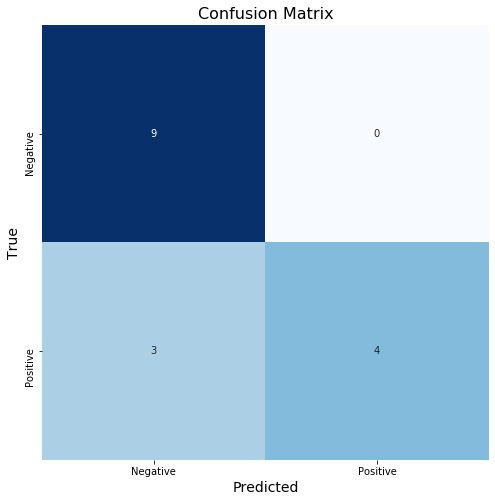

In [90]:
plt.figure(figsize = (8,8))
ax = plt.subplot()
sns.heatmap(cm, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('True', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

### ROC Curve and AUC ROC

In [91]:
y_pred_proba = vc.predict_proba(X_test_sc)

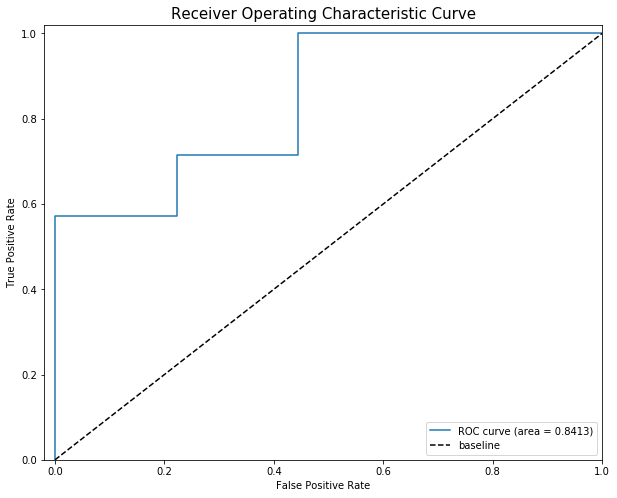

In [92]:
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)


# Plot of a ROC curve for a specific class
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve', fontsize=15)
plt.legend(loc="lower right");